# Understanding MessagePassing in Pytorch Geometric

## Resources
- https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
- http://pages.di.unipi.it/citraro/files/slides/Landolfi_tutorial.pdf
- https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
- https://www.notion.so/Graph-Neural-Networks-for-Novice-Math-Fanatics-fbd3e24de151412eb8915be11d4525d5

In [18]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger

In [159]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_scatter import scatter

In [2]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

In [4]:
edge_index

tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]])

In [9]:
edges = edge_index.numpy()
edges

array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 1]])

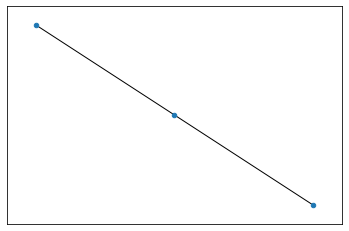

In [13]:
G = nx.Graph()
G.add_edges_from(edges)
nx.draw_networkx(G, with_labels=False, node_size=20)

In [14]:
data = Data(x=x, edge_index=edge_index.t().contiguous())

In [15]:
data

Data(x=[3, 1], edge_index=[2, 4])

In [203]:
"""
- What information does row and col hold?
- What does degree() do?
- Why do we use degree(col, ...) rather than degree(row, ...)?
- What does deg_inv_sqrt[col] and deg_inv_sqrt[row] do?
- What information does x_j hold in the message() function? If self.lin denotes the identity function, what is the exact content of x_j?
- Add an update() function to GCNConv that adds transformed central node features to the aggregated output.
"""
class DummyGConv(MessagePassing):
    def __init__(self, in_dim=1, out_dim=2):
        super().__init__(aggr='add')
        self.linear = torch.nn.Linear(in_dim, out_dim)
    
    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.shape[0])
#         logger.info(edge_index.shape)
        row, col = edge_index
        deg = degree(col, x.shape[0], dtype=x.dtype) # we can use both row and col
        logger.info(deg)
        deg_inv_sqrt = deg.pow(0.5)
        deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0
#         logger.info(deg_inv_sqrt)
#         logger.info(deg_inv_sqrt[row])
#         logger.info(deg_inv_sqrt[col])
        norm  = deg_inv_sqrt[row] * deg_inv_sqrt[col]
#         logger.info(norm)
        logger.info(f"|before linear layer {x.shape}|") 
        x = self.linear(x)
        logger.info(x)
        logger.info(f"|after linear layer {x.shape}|") 
        
        out = self.propagate(edge_index, x=x, norm=norm)  
        # the propagate calls 
           # - message
           # - aggregate
           # - update
        return out
    
    
    def my_exp(self, msg, edge_index):
        row, col = edge_index
        re = scatter(msg, col, dim=0, reduce='sum') # Scatter can be used to aggreg
        logger.info(re)
        
    def message(self, x_i, x_j, norm, edge_index):
        # x_i and  x_j is the node feature of nodes in source and nodes in destination respectively
        logger.info(f"{x_i.shape}")
        logger.info(f"{x_j.shape}")
        # x_j has shape [E, Out channels]
        logger.info(f"{norm.shape}")
        logger.info(f"{norm.view(-1, 1).shape}")
        msg = norm.view(-1, 1) * x_j # element wise product
        logger.info(f"{msg.shape}")
        logger.info(f"{msg}")
        # now this msg goes to aggregation part
        
        self.my_exp(msg, edge_index)
        
        return msg 
    
    def update(self, aggr_out, x):
        logger.info(x)
        logger.info(aggr_out)
        return aggr_out

In [204]:
dummy_gconv = DummyGConv(in_dim=1, out_dim=2)

In [205]:
dummy_gconv(data.x, data.edge_index)

2022-03-05 23:46:49.332 | INFO     | __main__:forward:22 - tensor([2., 3., 2.])
2022-03-05 23:46:49.334 | INFO     | __main__:forward:30 - |before linear layer torch.Size([3, 1])|
2022-03-05 23:46:49.335 | INFO     | __main__:forward:32 - tensor([[-0.7692, -0.1593],
        [-0.8021, -0.1963],
        [-0.8350, -0.2333]], grad_fn=<AddmmBackward>)
2022-03-05 23:46:49.337 | INFO     | __main__:forward:33 - |after linear layer torch.Size([3, 2])|
2022-03-05 23:46:49.338 | INFO     | __main__:message:50 - torch.Size([7, 2])
2022-03-05 23:46:49.338 | INFO     | __main__:message:51 - torch.Size([7, 2])
2022-03-05 23:46:49.339 | INFO     | __main__:message:53 - torch.Size([7])
2022-03-05 23:46:49.340 | INFO     | __main__:message:54 - torch.Size([7, 1])
2022-03-05 23:46:49.340 | INFO     | __main__:message:56 - torch.Size([7, 2])
2022-03-05 23:46:49.342 | INFO     | __main__:message:57 - tensor([[-1.8841, -0.3901],
        [-1.9647, -0.4808],
        [-1.9647, -0.4808],
        [-2.0453, -0.5

tensor([[-3.5030, -0.7993],
        [-6.3356, -1.5504],
        [-3.6347, -0.9474]], grad_fn=<ScatterAddBackward>)